## Importing the libraries

In [4]:
import os
import numpy as np
import pandas as pd
#import matplotlib
#matplotlib.rcParams['text.usetex'] = True
import matplotlib.pyplot as plt

import seaborn as sns
%matplotlib inline


from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error

## Reading in the data files

In [5]:
df_listings = pd.read_csv('Data/listings.csv', dtype={'listing_url': 'object',
                                                      'price': 'object',
                                                      'weekly_price': 'object',
                                                      'monthly_price': 'object',
                                                      'security_deposit': 'object',
                                                      'cleaning_fee': 'object',
                                                      'extra_people': 'object',
                                                      'license': 'object', 
                                                      'jurisdiction_names': 'object',})

## Data Exploration

### Listings Dataframe

In [6]:
df_listings.shape

(86358, 106)

In [7]:
pd.set_option('display.max_columns', None)

# show listings data sample
df_listings.head(3)

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,notes,transit,access,interaction,house_rules,thumbnail_url,medium_url,picture_url,xl_picture_url,host_id,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,street,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,city,state,zipcode,market,smart_location,country_code,country,latitude,longitude,is_location_exact,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,amenities,square_feet,price,weekly_price,monthly_price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,number_of_reviews_ltm,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,is_business_travel_ready,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,13913,https://www.airbnb.com/rooms/13913,20200414180850,2020-04-16,Holiday London DB Room Let-on going,My bright double bedroom with a large window h...,"Hello Everyone, I'm offering my lovely double ...",My bright double bedroom with a large window h...,business,Finsbury Park is a friendly melting pot commun...,For art lovers I can give guest my Tate Member...,The flat only a 10 minute walk to Finsbury Par...,Guest will have access to the self catering ki...,I like to have little chats with my guest over...,I'm an artist and have my artwork up on the wa...,NaN,NaN,https://a0.muscache.com/im/pictures/ffb507b7-9...,NaN,54730,https://www.airbnb.com/users/show/54730,Alina,2009-11-16,"London, England, United Kingdom",I am a Multi-Media Visual Artist and Creative ...,within a few hours,71%,89%,f,https://a0.muscache.com/im/users/54730/profile...,https://a0.muscache.com/im/users/54730/profile...,LB of Islington,4.0,4.0,"['email', 'phone', 'facebook', 'reviews', 'off...",t,t,"Islington, Greater London, United Kingdom",LB of Islington,Islington,NaN,Islington,Greater London,N4 3,London,"Islington, United Kingdom",GB,United Kingdom,51.56802,-0.11121,t,Apartment,Private room,2,1.0,1.0,0.0,Real Bed,"{TV,""Cable TV"",Wifi,Kitchen,""Paid parking off ...",538.0,$65.00,$333.00,"$1,176.00",$100.00,$15.00,1,$15.00,1,29,1,1,29,29,1.0,29.0,12 months ago,t,27,57,84,359,2020-04-16,21,7,2010-08-18,2020-02-22,97.0,10.0,10.0,10.0,10.0,9.0,9.0,f,NaN,NaN,f,f,moderate,f,f,2,1,1,0,0.18
1,15400,https://www.airbnb.com/rooms/15400,20200414180850,2020-04-16,Bright Chelsea Apartment. Chelsea!,Lots of windows and light. St Luke's Gardens ...,Bright Chelsea Apartment This is a bright one...,Lots of windows and light. St Luke's Gardens ...,romantic,It is Chelsea.,The building next door is in the process of be...,The underground stations are South Kensington ...,There are two wardrobes for guests exclusive u...,If I am in the country I like to welcome my gu...,NO SMOKING PLEASE.. No unauthorised guests. No...,NaN,NaN,https://a0.muscache.com/im/pictures/428392/462...,NaN,60302,https://www.airbnb.com/users/show/60302,Philippa,2009-12-05,"Kensington, England, United Kingdom","English, grandmother, I have travelled quite ...",within a day,50%,67%,f,https://a0.musc

In [8]:
df_listings.describe()

,id,scrape_id,thumbnail_url,medium_url,xl_picture_url,host_id,host_listings_count,host_total_listings_count,neighbourhood_group_cleansed,latitude,longitude,accommodates,bathrooms,bedrooms,beds,square_feet,guests_included,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,availability_30,availability_60,availability_90,availability_365,number_of_reviews,number_of_reviews_ltm,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
count,8.635800e+04,8.635800e+04,0.0,0.0,0.0,8.635800e+04,86348.000000,86348.000000,0.0,86358.000000,86358.000000,86358.000000,86226.000000,86216.000000,85416.000000,378.000000,86358.000000,86358.000000,8.635800e+04,86358.000000,86358.000000,8.635800e+04,8.635800e+04,86358.000000,8.635800e+04,86358.000000,86358.000000,86358.000000,86358.000000,86358.000000,86358.000000,63201.000000,63140.000000,63150.000000,63091.000000,63145.000000,63092.000000,63091.000000,86358.000000,86358.000000,86358.000000,86358.000000,64842.000000
mean,2.511516e+07,2.020041e+13,NaN,NaN,NaN,9.334733e+07,25.805450,25.805450,NaN,51.509916,-0.128245,3.211793,1.312122,1.415399,1.756580,643.611111,1.610760,4.474490,1.859559e+04,4.611142,5.812895,4.352354e+04,6.403469e+05,5.213305,6.099044e+05,7.870944,20.663239,33.379201,116.328898,17.531277,6.039417,92.491938,9.498464,9.256089,9.619375,9.642949,9.545346,9.253428,20.987448,17.973506,2.392390,0.052224,0.963183
std,1.238307e+07,1.269929e+01,NaN,NaN,NaN,9.543753e+07,134.219607,134.219607,NaN,0.046204,0.093286,2.033954,0.611861,0.920860,1.291133,849.684376,1.368455,19.151568,3.843374e+06,25.141390,29.128662,8.256667e+06,3.673454e+07,27.244416,3.496024e+07,10.379774,22.536341,35.047341,135.293902,37.393948,11.836707,10.357702,1.007258,1.156111,0.917570,0.913096,0.834854,1.057238,100.232081,98.678139,13.027134,0.712945,1.177591
min,1.391300e+04,2.020041e+13,NaN,NaN,NaN,4.775000e+03,0.000000,0.000000,NaN,51.294790,-0.510310,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000e+00,1.000000,1.000000,1.000000e+00,1.000000e+00,1.000000,1.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,20.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,1.000000,0.000000,0.000000,0.000000,0.010000
25%,1.553035e+07,2.020041e+13,NaN,NaN,NaN,1.636343e+07,1.000000,1.000000,NaN,51.485850,-0.188380,2.000000,1.000000,1.000000,1.000000,130.000000,1.000000,1.000000,3.100000e+01,1.000000,1.000000,6.000000e+01,9.000000e+01,1.000000,8.500000e+01,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,90.000000,9.000000,9.000000,10.000000,10.000000,9.000000,9.000000,1.000000,0.000000,0.000000,0.000000,0.200000
50%,2.573346e+07,2.020041e+13,NaN,NaN,NaN,5.013476e+07,1.000000,1.000000,NaN,51.514080,-0.126245,2.000000,1.000000,1.000000,1.000000,522.000000,1.000000,2.000000,1.125000e+03,2.000000,2.000000,1.125000e+03,1.125000e+03,2.000000,1.125000e+03,0.000000,8.000000,16.000000,63.000000,4.000000,1.000000,96.000000,10.000000,10.000000,10.000000,10.000000,10.000000,9.000000,1.000000,1.000000,1.000000,0.000000,0.560000
75%,3.654165e+07,2.020041e+13,NaN,NaN,NaN,1.522947e+08,5.000000,5.000000,NaN,51.537620,-0.069930,4.000000,1.500000,2.000000,2.000000,861.000000,2.000000,3.000000,1.125000e+03,3.000000,4.000000,1.125000e+03,1.125000e+03,3.500000,1.125000e+03,12.000000,39.000000,68.000000,237.000000,17.000000,7.000000,100.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,5.000000,2.000000,1.000000,0.000000,1.270000
max,4.318679e+07,2.020041e+13,NaN,NaN,NaN,3.437914e+08,1237.000000,1237.000000,NaN,51.681690,0.284500,32.000000,17.000000,24.000000,28.000000,10710.000000,46.00000

In [9]:
set(df_listings.columns[df_listings.isnull().mean()>0.75])

{'jurisdiction_names',
 'license',
 'medium_url',
 'monthly_price',
 'neighbourhood_group_cleansed',
 'square_feet',
 'thumbnail_url',
 'weekly_price',
 'xl_picture_url'}

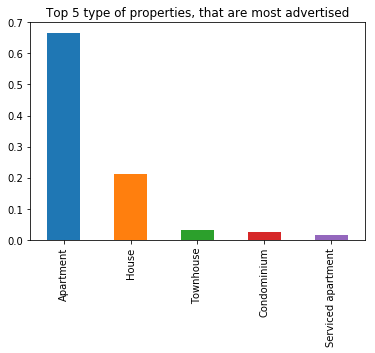

In [10]:
neighbourhood_vals = df_listings['property_type'].value_counts()

# The below should be a bar chart of the proportion of individuals in each professional category if your status_vals
# is set up correctly.

(neighbourhood_vals[0:5]/df_listings.shape[0]).plot(kind="bar");
plt.title("Top 5 type of properties, that are most advertised");

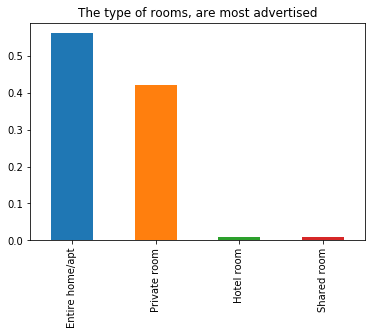

In [11]:
room_vals = df_listings['room_type'].value_counts()

# The below should be a bar chart of the proportion of individuals in each professional category if your status_vals
# is set up correctly.

(room_vals/df_listings.shape[0]).plot(kind="bar");
plt.title("The type of rooms, are most advertised");

## The Business Questions

### What are Airbnb current challanges?

### Question 1
- What is the average price of the listings, for the different location within London?

In [12]:
price_df = df_listings[df_listings['price'].isnull() == False]

In [13]:
price_df['neighbourhood_cleansed'].value_counts()

Westminster               9943
Tower Hamlets             8321
Camden                    6243
Hackney                   6210
Kensington and Chelsea    6079
Islington                 5019
Southwark                 4957
Lambeth                   4881
Wandsworth                4261
Hammersmith and Fulham    4233
Brent                     2605
Lewisham                  2326
Haringey                  2233
Newham                    2071
Ealing                    1790
Greenwich                 1736
Barnet                    1670
Waltham Forest            1476
Merton                    1364
Richmond upon Thames      1217
Hounslow                  1105
Croydon                   1091
Redbridge                  752
Enfield                    710
Hillingdon                 666
Bromley                    654
Kingston upon Thames       550
City of London             491
Harrow                     473
Barking and Dagenham       396
Sutton                     318
Bexley                     261
Havering

In [14]:
price_df['price'] = price_df['price'].str.replace('$', '', regex=True)
price_df['price'] = price_df['price'].str.replace(',', '', regex=True)
price_df['price'] = price_df['price'].astype(float)

In [15]:
nb_price_avg = price_df.groupby('neighbourhood_cleansed', as_index=False).mean()
nb_price_avg = pd.DataFrame(nb_price_avg).sort_values(by='price', ascending=False)

In [16]:
nb_price_avg = nb_price_avg.rename(columns={'neighbourhood_cleansed':'Neighbourhood','price': 'Avg Price'})

[Text(0,0,'Westminster'),
 Text(0,0,'Kensington and Chelsea'),
 Text(0,0,'City of London'),
 Text(0,0,'Camden'),
 Text(0,0,'Hammersmith and Fulham'),
 Text(0,0,'Richmond upon Thames'),
 Text(0,0,'Wandsworth'),
 Text(0,0,'Southwark'),
 Text(0,0,'Islington'),
 Text(0,0,'Merton'),
 Text(0,0,'Hounslow'),
 Text(0,0,'Brent'),
 Text(0,0,'Lambeth'),
 Text(0,0,'Tower Hamlets'),
 Text(0,0,'Hackney'),
 Text(0,0,'Barnet'),
 Text(0,0,'Haringey'),
 Text(0,0,'Greenwich'),
 Text(0,0,'Ealing'),
 Text(0,0,'Sutton'),
 Text(0,0,'Newham'),
 Text(0,0,'Kingston upon Thames'),
 Text(0,0,'Harrow'),
 Text(0,0,'Waltham Forest'),
 Text(0,0,'Redbridge'),
 Text(0,0,'Lewisham'),
 Text(0,0,'Hillingdon'),
 Text(0,0,'Havering'),
 Text(0,0,'Enfield'),
 Text(0,0,'Bromley'),
 Text(0,0,'Barking and Dagenham'),
 Text(0,0,'Croydon'),
 Text(0,0,'Bexley')]

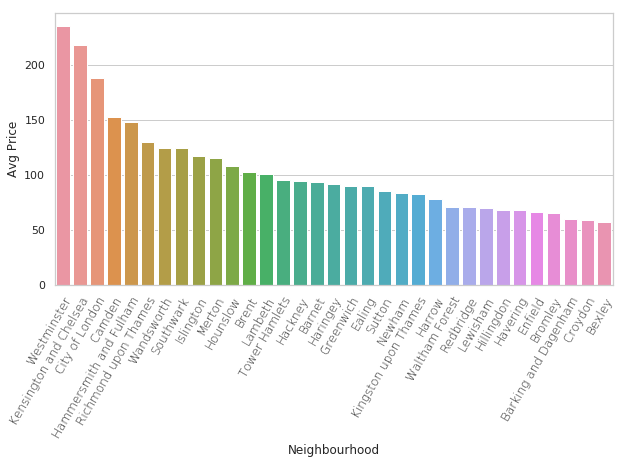

In [17]:
plt.figure(figsize=(10,5))

sns.set(style="whitegrid")
chart = sns.barplot(x="Neighbourhood", y="Avg Price", data=nb_price_avg)

chart.set_xticklabels(
    chart.get_xticklabels(), 
    rotation=60, 
    horizontalalignment='right',
    fontweight='light',
    fontsize='medium', 
    rotation_mode='anchor'
)

### Question 2

- What types of verifications are hosts using? How long did it take them to respond?

In [18]:
verifications_df = df_listings[df_listings['host_verifications'].isnull() == False]

In [19]:
verifications_df.shape

(86358, 106)

In [20]:
verifications_df = verifications_df[verifications_df['host_verifications'] != '[]']

In [21]:
verifications_df.shape

(86272, 106)

In [22]:
verifications_df['host_verifications'].value_counts()

['email', 'phone', 'reviews', 'jumio', 'government_id']                                                                                                            9206
['email', 'phone']                                                                                                                                                 8562
['email', 'phone', 'reviews', 'jumio', 'offline_government_id', 'selfie', 'government_id', 'identity_manual']                                                      6470
['email', 'phone', 'reviews']                                                                                                                                      5497
['email', 'phone', 'offline_government_id', 'selfie', 'government_id', 'identity_manual']                                                                          4872
['email', 'phone', 'reviews', 'jumio', 'offline_government_id', 'government_id']                                                                                

In [23]:
def verifications_types(column):
    verifications_dict = {}
    temp = []

    for i in column:
        temp.append(eval(i))
    
    for i in temp:
        try:
            for j in i:
                if j not in verifications_dict:
                    verifications_dict[j] = 1
                else:
                    verifications_dict[j] += 1
        except:
            continue
            
    return verifications_dict
        
verifications_types = verifications_types(verifications_df['host_verifications'])

In [24]:
verifications_types

{'email': 79397,
 'phone': 85821,
 'facebook': 14257,
 'reviews': 55107,
 'offline_government_id': 42144,
 'selfie': 29315,
 'government_id': 64097,
 'jumio': 49014,
 'identity_manual': 27303,
 'work_email': 13213,
 'kba': 403,
 'manual_offline': 1614,
 'manual_online': 739,
 'google': 4121,
 'sent_id': 94,
 'photographer': 2,
 'weibo': 46,
 'sesame': 19,
 'sesame_offline': 19,
 'zhima_selfie': 32}

In [25]:
for k,v in verifications_types.items():
    verifications_types[k] = round(v / verifications_df.shape[0] * 100, 3)

In [26]:
verifications_types

{'email': 92.031,
 'phone': 99.477,
 'facebook': 16.526,
 'reviews': 63.876,
 'offline_government_id': 48.85,
 'selfie': 33.98,
 'government_id': 74.296,
 'jumio': 56.813,
 'identity_manual': 31.648,
 'work_email': 15.316,
 'kba': 0.467,
 'manual_offline': 1.871,
 'manual_online': 0.857,
 'google': 4.777,
 'sent_id': 0.109,
 'photographer': 0.002,
 'weibo': 0.053,
 'sesame': 0.022,
 'sesame_offline': 0.022,
 'zhima_selfie': 0.037}

In [27]:
verifications_types = pd.DataFrame.from_dict(verifications_types,orient='index',columns=['A']).reset_index()
verifications_types = verifications_types.rename(columns={'index':'Verification Type','A': '% of listings'})
verifications_types = verifications_types.sort_values(by='% of listings', ascending=False)

In [28]:
verifications_types

,Verification Type,% of listings
1,phone,99.477
0,email,92.031
6,government_id,74.296
3,reviews,63.876
7,jumio,56.813
4,offline_government_id,48.850
5,selfie,33.980
8,identity_manual,31.648
2,facebook,16.526
9,work_email,15.316


[Text(0,0,'phone'),
 Text(0,0,'email'),
 Text(0,0,'government_id'),
 Text(0,0,'reviews'),
 Text(0,0,'jumio'),
 Text(0,0,'offline_government_id'),
 Text(0,0,'selfie'),
 Text(0,0,'identity_manual'),
 Text(0,0,'facebook'),
 Text(0,0,'work_email'),
 Text(0,0,'google'),
 Text(0,0,'manual_offline'),
 Text(0,0,'manual_online'),
 Text(0,0,'kba'),
 Text(0,0,'sent_id'),
 Text(0,0,'weibo'),
 Text(0,0,'zhima_selfie'),
 Text(0,0,'sesame'),
 Text(0,0,'sesame_offline'),
 Text(0,0,'photographer')]

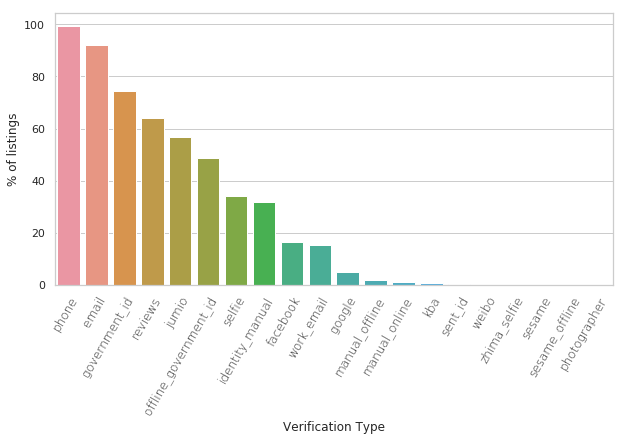

In [29]:
plt.figure(figsize=(10,5))

sns.set(style="whitegrid")
chart = sns.barplot(x="Verification Type", y="% of listings", data=verifications_types)

chart.set_xticklabels(
    chart.get_xticklabels(), 
    rotation=60, 
    horizontalalignment='right',
    fontweight='light',
    fontsize='medium', 
    rotation_mode='anchor'
)

### Question 3
- What features assist in the pricing of a listing? 
    - Could the price be predicted?
    - importance of the features, rank features

#### Cleaning the data

In [30]:
col_nulls = set(df_listings.columns[df_listings.isnull().mean()>0.70])

In [31]:
df = df_listings.drop(list(col_nulls), axis=1)
df = df[df.columns.drop(list(df.filter(regex='url')))]
df = df[df.columns.drop(list(df.filter(regex='id')))]
df = df[df.columns.drop(list(df.filter(regex='scraped')))]
df = df[df.columns.drop(list(df.filter(regex='first_review')))]
df = df[df.columns.drop(list(df.filter(regex='last_review')))]

In [32]:
df = df.drop(columns=['name','summary','space','description','neighborhood_overview','notes',
                     'transit','access','interaction','house_rules','host_name','host_about',
                      'host_since','host_neighbourhood','street','neighbourhood','market','latitude','longitude',
                     'host_location','city','state','zipcode','smart_location','country_code','country'])

In [33]:
df = df.dropna(subset=["price"])

In [34]:
df.head(3)

,experiences_offered,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,neighbourhood_cleansed,is_location_exact,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,amenities,price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,number_of_reviews,number_of_reviews_ltm,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,requires_license,instant_bookable,is_business_travel_ready,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,business,within a few hours,71%,89%,f,4.0,4.0,"['email', 'phone', 'facebook', 'reviews', 'off...",t,Islington,t,Apartment,Private room,2,1.0,1.0,0.0,Real Bed,"{TV,""Cable TV"",Wifi,Kitchen,""Paid parking off ...",$65.00,$100.00,$15.00,1,$15.00,1,29,1,1,29,29,1.0,29.0,12 months ago,t,27,57,84,359,21,7,97.0,10.0,10.0,10.0,10.0,9.0,9.0,f,f,f,moderate,f,f,2,1,1,0,0.18
1,romantic,within a day,50%,67%,f,1.0,1.0,"['email', 'phone', 'reviews', 'jumio', 'govern...",t,Kensington and Chelsea,t,Apartment,Entire home/apt,2,1.0,1.0,1.0,Real Bed,"{TV,""Cable TV"",Internet,Wifi,""Air conditioning...",$100.00,$150.00,$50.00,2,$0.00,10,50,10,10,50,50,10.0,50.0,3 months ago,t,3,3,5,232,89,6,96.0,10.0,10.0,10.0,10.0,10.0,9.0,f,t,f,strict_14_with_grace_period,t,t,1,1,0,0,0.71
2,none,within an hour,80%,94%,f,18.0,18.0,"['email', 'phone', 'reviews', 'jumio', 'offlin...",t,Westminster,f,Apartment,Entire home/apt,6,2.0,3.0,3.0,Real Bed,"{TV,Wifi,Kitchen,""Paid parking off premises"",E...",$300.00,$350.00,$90.00,3,$10.00,3,365,3,5,60,365,3.2,327.0,4 weeks ago,t,21,51,69,307,42,3,94.0,10.0,9.0,9.0,9.0,10.0,9.0,f,t,f,strict_14_with_grace_period,f,f,15,15,0,0,0.38


In [35]:
pd.set_option('display.max_rows', None)

df.dtypes

experiences_offered                              object
host_response_time                               object
host_response_rate                               object
host_acceptance_rate                             object
host_is_superhost                                object
host_listings_count                             float64
host_total_listings_count                       float64
host_verifications                               object
host_has_profile_pic                             object
neighbourhood_cleansed                           object
is_location_exact                                object
property_type                                    object
room_type                                        object
accommodates                                      int64
bathrooms                                       float64
bedrooms                                        float64
beds                                            float64
bed_type                                        

In [36]:
def data_float(column):
    column = column.str.replace('$', '', regex=True)
    column = column.str.replace(',', '', regex=True)
    column = column.astype(float)
    
    return column

df['price'] = data_float(df['price'])
df['security_deposit'] = data_float(df['security_deposit'])
df['cleaning_fee'] = data_float(df['cleaning_fee'])
df['extra_people'] = data_float(df['extra_people'])

In [37]:
def data_percentage(column):
    column = column.str.replace('%', '', regex=True)
    #column = column.str.replace(',', '', regex=True)
    column = column.astype('float') / 100
    
    return column

df['host_response_rate'] = data_percentage(df['host_response_rate'])
df['host_acceptance_rate'] = data_percentage(df['host_acceptance_rate'])

In [38]:
num_vars = df.select_dtypes(include=['float', 'int']).columns
for col in num_vars:
    df[col].fillna((df[col].mean()), inplace=True)

In [39]:
df['host_response_time'].fillna('No Response', inplace=True)
df['host_is_superhost'].fillna('f', inplace=True)
df['host_has_profile_pic'].fillna('f', inplace=True)
df['bed_type'].fillna('Unknown', inplace=True)

In [40]:
df.isnull().sum()

experiences_offered                             0
host_response_time                              0
host_response_rate                              0
host_acceptance_rate                            0
host_is_superhost                               0
host_listings_count                             0
host_total_listings_count                       0
host_verifications                              0
host_has_profile_pic                            0
neighbourhood_cleansed                          0
is_location_exact                               0
property_type                                   0
room_type                                       0
accommodates                                    0
bathrooms                                       0
bedrooms                                        0
beds                                            0
bed_type                                        0
amenities                                       0
price                                           0


In [ ]:
# Dummy the categorical variables
cat_vars = df.select_dtypes(include=['object']).copy().columns
for var in  cat_vars:
    # for each cat add dummy var, drop original column
    df = pd.concat([df.drop(var, axis=1), pd.get_dummies(df[var],
                                                         prefix=var, prefix_sep='_', drop_first=True)], axis=1)

#### Building the Model

In [ ]:
X = df.drop('price', axis = 1)
y = df['price']

In [ ]:
X.shape

In [ ]:
X_new = SelectKBest(chi2, k=20).fit_transform(X, y)

In [ ]:
X_new.shape

In [ ]:
#split the data into train and test
X_train, X_test, y_train, y_test = train_test_split(X_new, y, test_size = 0.2, random_state=42)

In [ ]:
#fit the model
lm_model = LinearRegression()
lm_model.fit(X_train, y_train)

In [ ]:
y_test_preds = lm_model.predict(X_test)

In [ ]:
#Predict and score the model
#y_test_preds = pipeline.predict(X_test) 
"The r-squared score for the model using only quantitative variables was {} on {} values.".format(r2_score(y_test, y_test_preds), len(y_test))